In [1]:
%matplotlib inline

import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pprint

from starfish import data, FieldOfView
from starfish.types import Features, Axes
from starfish.util.plot import imshow_plane

/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.12.2. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
matplotlib.rcParams["figure.dpi"] = 150


In [3]:
use_test_data = os.getenv("USE_TEST_DATA") is not None

# An experiment contains a codebook, primary images, and auxiliary images
experiment = data.ISS(use_test_data=use_test_data)
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment._src_doc)

{ 'codebook': 'codebook.json',
  'extras': {},
  'images': { 'dots': 'dots.json',
              'nuclei': 'nuclei.json',
              'primary': 'primary_images.json'},
  'version': '5.0.0'}


In [4]:
fov = experiment.fov()

# note the structure of the 5D tensor containing the raw imaging data
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)
print(imgs)

100%|██████████| 16/16 [00:00<00:00, 20.79it/s]

<starfish.ImageStack (r: 4, c: 4, z: 1, y: 1044, x: 1390)>


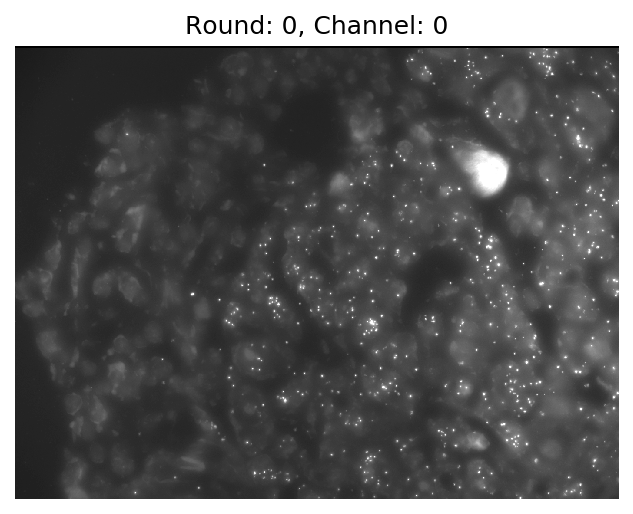

In [5]:
# # Display all the data in an interactive pop-up window. Uncomment to have this version work.
# %gui qt5
# display(imgs)

# Display a single plane of data
sel={Axes.ROUND: 0, Axes.CH: 0, Axes.ZPLANE: 0}
single_plane = imgs.sel(sel)
imshow_plane(single_plane, title="Round: 0, Channel: 0")

100%|██████████| 1/1 [00:00<00:00, 96.70it/s]


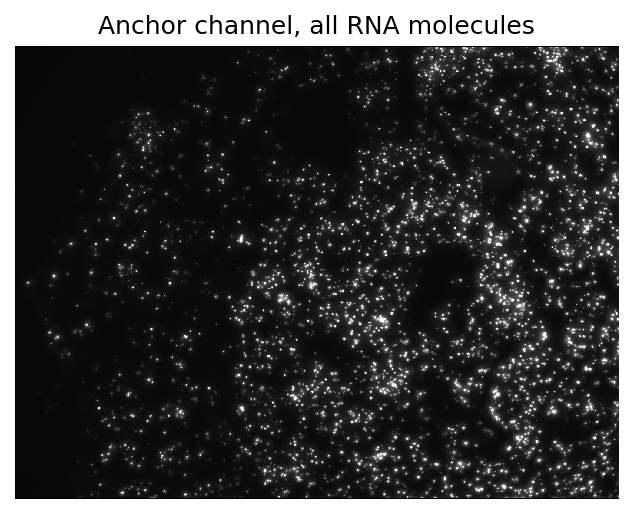

In [6]:
from starfish.image import Filter

rcz_max_projector = Filter.Reduce(
    (Axes.ROUND, Axes.CH, Axes.ZPLANE,), func="max", module=Filter.Reduce.FunctionSource.np)
per_round_max_projector = Filter.Reduce(
    (Axes.CH, Axes.ZPLANE,), func="max", module=Filter.Reduce.FunctionSource.np)

dots = fov.get_image("dots")
dots_single_plane = rcz_max_projector.run(dots)
imshow_plane(dots_single_plane, title="Anchor channel, all RNA molecules")

100%|██████████| 1/1 [00:00<00:00, 92.91it/s]


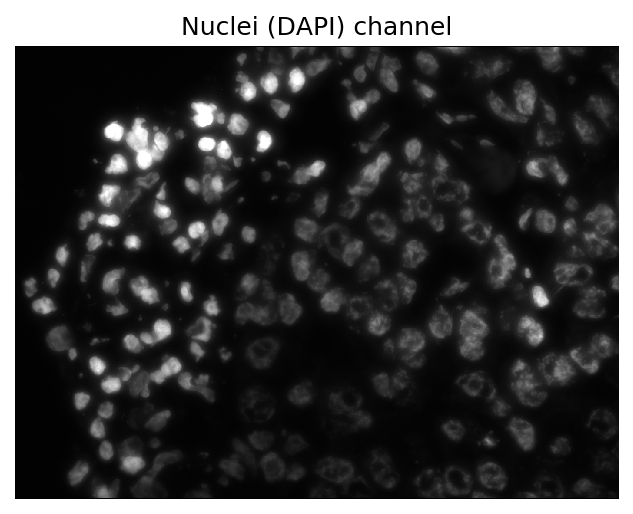

In [7]:
nuclei = fov.get_image("nuclei")
nuclei_single_plane = rcz_max_projector.run(nuclei)
imshow_plane(nuclei_single_plane, title="Nuclei (DAPI) channel")

In [8]:
from starfish.image import Filter

# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)

filtered_imgs = filt.run(imgs, verbose=True, in_place=False)
filt.run(dots, verbose=True, in_place=True)
filt.run(nuclei, verbose=True, in_place=True)

16it [00:19,  1.26s/it]
1it [00:00, 15.00it/s]
1it [00:00, 13.69it/s]


<starfish.ImageStack (r: 1, c: 1, z: 1, y: 1044, x: 1390)>

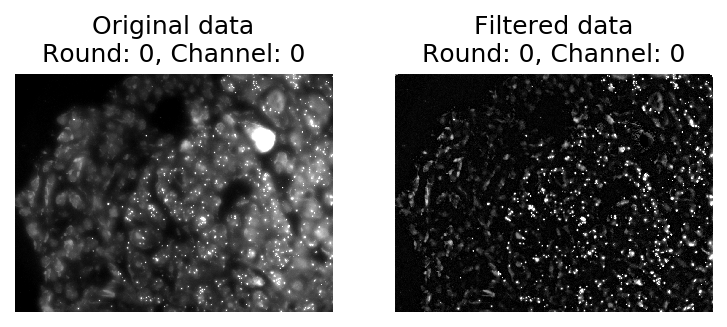

In [9]:
single_plane_filtered = filtered_imgs.sel(sel)

f, (ax1, ax2) = plt.subplots(ncols=2)
vmin, vmax = np.percentile(single_plane.xarray.values.data, [5, 99])
imshow_plane(
    single_plane, ax=ax1, vmin=vmin, vmax=vmax, 
    title="Original data\nRound: 0, Channel: 0"
)
vmin, vmax = np.percentile(single_plane_filtered.xarray.values.data, [5, 99])
imshow_plane(
    single_plane_filtered, ax=ax2, vmin=vmin, vmax=vmax, 
    title="Filtered data\nRound: 0, Channel: 0"
)

In [10]:
from starfish.image import ApplyTransform, LearnTransform

learn_translation = LearnTransform.Translation(reference_stack=dots, axes=Axes.ROUND, upsampling=1000)
transforms_list = learn_translation.run(per_round_max_projector.run(imgs))
warp = ApplyTransform.Warp()
registered_imgs = warp.run(filtered_imgs, transforms_list=transforms_list, in_place=False, verbose=True)

100%|██████████| 4/4 [00:00<00:00, 79.41it/s]


In [14]:
from starfish.spots import DetectSpots
import warnings

# parameters to define the allowable gaussian sizes (parameter space)
p = DetectSpots.PixelSpotDetector(
    min_sigma=1,
    max_sigma=10,
    num_sigma=30,
    threshold=0.01,
    measurement_type='mean',
)

# blobs = dots; define the spots in the dots image, but then find them again in the stack.
intensities = p.run(registered_imgs, blobs_image=dots, blobs_axes=(Axes.ROUND, Axes.ZPLANE))

AttributeError: type object 'DetectSpots' has no attribute 'PixelSpotDetector'

also called "PixelSpotDecoding" as in https://github.com/spacetx/starfish/issues/1273